In [80]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
products = pd.read_csv('amazon_baby_subset.csv')

In [82]:
def remove_punctuation(text):
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~+='''

    # remove punctuation from the string
    no_punct = ""
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + " "
            
    return no_punct

In [83]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [84]:
index=0
review_without_puctuation = pd.Series([])
for i in products['review']:
    review_without_puctuation[index] = remove_punctuation(i)
    index += 1

products.insert(products.shape[1], "review_clean", review_without_puctuation) 

In [85]:
with open('important_words.json') as important_words_file:    
    important_words = json.load(important_words_file)

for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [86]:
with open('module-4-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)
with open('module-4-assignment-validation-idx.json') as validation_data_file:    
    validation_data_idx = json.load(validation_data_file)

train_data = products.iloc[train_data_idx]
validation_data = products.iloc[validation_data_idx]

In [87]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)

In [88]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [89]:
def predict_probability(feature_matrix, coefficients):
    
    score = np.dot(feature_matrix, coefficients) 
    predictions = 1.0/(1+np.exp(-score))
    
    return predictions

In [90]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    derivative = np.dot(np.transpose(errors), feature)

    if not feature_is_constant: 
        derivative -= 2 * l2_penalty * coefficient
        
    return derivative

The intercept term in the above function is not regularized

In [91]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((np.transpose(np.array([indicator]))-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

The term with L2 regularization decrease ℓℓ(w)

In [92]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = np.transpose(np.array([indicator])) - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [93]:
initial_coefficients = np.zeros((194,1))
step_size = 5e-6
max_iter = 501

In [95]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 0, max_iter)

iteration   0: log likelihood of observed labels = -29174.46050205
iteration   1: log likelihood of observed labels = -28994.25530408
iteration   2: log likelihood of observed labels = -28821.00887189
iteration   3: log likelihood of observed labels = -28654.14559309
iteration   4: log likelihood of observed labels = -28493.21621683
iteration   5: log likelihood of observed labels = -28337.85105525
iteration   6: log likelihood of observed labels = -28187.73285381
iteration   7: log likelihood of observed labels = -28042.58082880
iteration   8: log likelihood of observed labels = -27902.14107563
iteration   9: log likelihood of observed labels = -27766.18064748
iteration  10: log likelihood of observed labels = -27634.48377157
iteration  11: log likelihood of observed labels = -27506.84932458
iteration  12: log likelihood of observed labels = -27383.08905915
iteration  13: log likelihood of observed labels = -27263.02628654
iteration  14: log likelihood of observed labels = -27146.4948

In [96]:
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 4, max_iter)

iteration   0: log likelihood of observed labels = -29174.46430167
iteration   1: log likelihood of observed labels = -28994.27745587
iteration   2: log likelihood of observed labels = -28821.06276989
iteration   3: log likelihood of observed labels = -28654.24363196
iteration   4: log likelihood of observed labels = -28493.36990141
iteration   5: log likelihood of observed labels = -28338.07108343
iteration   6: log likelihood of observed labels = -28188.02918408
iteration   7: log likelihood of observed labels = -28042.96273851
iteration   8: log likelihood of observed labels = -27902.61721297
iteration   9: log likelihood of observed labels = -27766.75907857
iteration  10: log likelihood of observed labels = -27635.17202366
iteration  11: log likelihood of observed labels = -27507.65442565
iteration  12: log likelihood of observed labels = -27384.01757446
iteration  13: log likelihood of observed labels = -27264.08435217
iteration  14: log likelihood of observed labels = -27147.6881

In [97]:
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 10, max_iter)

iteration   0: log likelihood of observed labels = -29174.47000111
iteration   1: log likelihood of observed labels = -28994.31068132
iteration   2: log likelihood of observed labels = -28821.14360602
iteration   3: log likelihood of observed labels = -28654.39066072
iteration   4: log likelihood of observed labels = -28493.60036677
iteration   5: log likelihood of observed labels = -28338.40101595
iteration   6: log likelihood of observed labels = -28188.47350264
iteration   7: log likelihood of observed labels = -28043.53533795
iteration   8: log likelihood of observed labels = -27903.33104225
iteration   9: log likelihood of observed labels = -27767.62621169
iteration  10: log likelihood of observed labels = -27636.20372459
iteration  11: log likelihood of observed labels = -27508.86120801
iteration  12: log likelihood of observed labels = -27385.40925639
iteration  13: log likelihood of observed labels = -27265.67010682
iteration  14: log likelihood of observed labels = -27149.4765

In [98]:
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 1e2, max_iter)

iteration   0: log likelihood of observed labels = -29174.55549265
iteration   1: log likelihood of observed labels = -28994.80874018
iteration   2: log likelihood of observed labels = -28822.35458443
iteration   3: log likelihood of observed labels = -28656.59184414
iteration   4: log likelihood of observed labels = -28497.04850335
iteration   5: log likelihood of observed labels = -28343.33423540
iteration   6: log likelihood of observed labels = -28195.11288651
iteration   7: log likelihood of observed labels = -28052.08627470
iteration   8: log likelihood of observed labels = -27913.98443507
iteration   9: log likelihood of observed labels = -27780.55957438
iteration  10: log likelihood of observed labels = -27651.58218425
iteration  11: log likelihood of observed labels = -27526.83842564
iteration  12: log likelihood of observed labels = -27406.12827306
iteration  13: log likelihood of observed labels = -27289.26412143
iteration  14: log likelihood of observed labels = -27176.0696

In [99]:
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 1e3, max_iter)

iteration   0: log likelihood of observed labels = -29175.41040801
iteration   1: log likelihood of observed labels = -28999.75611988
iteration   2: log likelihood of observed labels = -28834.30433785
iteration   3: log likelihood of observed labels = -28678.17107476
iteration   4: log likelihood of observed labels = -28530.63370186
iteration   5: log likelihood of observed labels = -28391.07643622
iteration   6: log likelihood of observed labels = -28258.95862261
iteration   7: log likelihood of observed labels = -28133.79577908
iteration   8: log likelihood of observed labels = -28015.14784444
iteration   9: log likelihood of observed labels = -27902.61154414
iteration  10: log likelihood of observed labels = -27795.81515405
iteration  11: log likelihood of observed labels = -27694.41469296
iteration  12: log likelihood of observed labels = -27598.09099328
iteration  13: log likelihood of observed labels = -27506.54733374
iteration  14: log likelihood of observed labels = -27419.5074

In [100]:
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train , sentiment_train , initial_coefficients, step_size, 1e5, max_iter)

iteration   0: log likelihood of observed labels = -29269.45109767
iteration   1: log likelihood of observed labels = -29269.28986723
iteration   2: log likelihood of observed labels = -29269.23512895
iteration   3: log likelihood of observed labels = -29269.18831829
iteration   4: log likelihood of observed labels = -29269.14604324
iteration   5: log likelihood of observed labels = -29269.10774959
iteration   6: log likelihood of observed labels = -29269.07305673
iteration   7: log likelihood of observed labels = -29269.04162581
iteration   8: log likelihood of observed labels = -29269.01315010
iteration   9: log likelihood of observed labels = -29268.98735176
iteration  10: log likelihood of observed labels = -29268.96397905
iteration  11: log likelihood of observed labels = -29268.94280390
iteration  12: log likelihood of observed labels = -29268.92361969
iteration  13: log likelihood of observed labels = -29268.90623923
iteration  14: log likelihood of observed labels = -29268.8904

In [101]:
coefficients_0_penalty_without_intercept = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients_0_penalty_without_intercept)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

In [102]:
positive_words = []
for i in range(5):
    positive_words.append(word_coefficient_tuples[:5][i][0])
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [103]:
negative_words = []
for i in range(5):
    negative_words.append(word_coefficient_tuples[-5:][i][0])
negative_words

['returned', 'waste', 'return', 'money', 'disappointed']

In [104]:
table = pd.DataFrame(data=[coefficients_0_penalty.flatten(), coefficients_4_penalty.flatten(), coefficients_10_penalty.flatten(), coefficients_1e2_penalty.flatten(), coefficients_1e3_penalty.flatten(), coefficients_1e5_penalty.flatten()], 
                     index=[0, 4, 10, 100.0, 1000.0, 100000.0],
                     columns=['(intercept)'] + important_words)

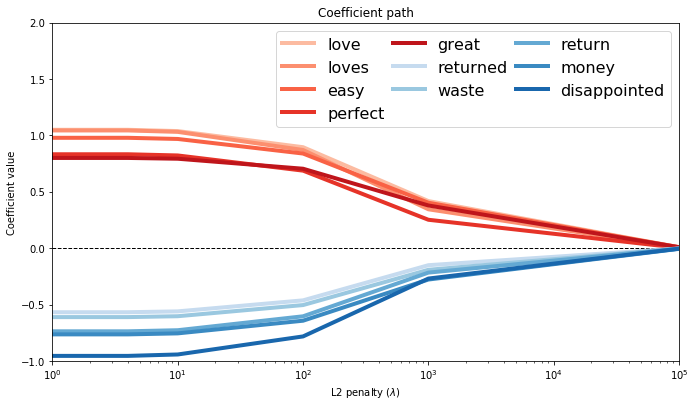

In [105]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    
    table_positive_words = table[positive_words] 
    table_negative_words = table[negative_words]
    #del table_positive_words['word']
    #del table_negative_words['word']
    
    for i, value in enumerate(positive_words):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[value].values.flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i, value in enumerate(negative_words):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[value].values.flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

So All coefficients consistently get smaller in size as L2 penalty is increased.

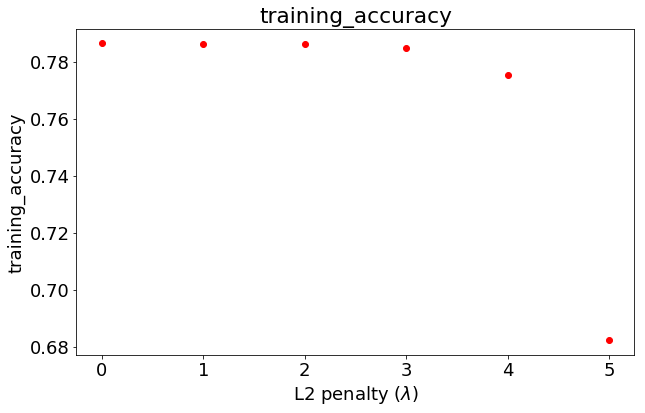

In [106]:
training_accuracy = []
for coefficient in [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty]:
    predictions = predict_probability(feature_matrix_train, coefficient)
    correct_num = np.sum((np.transpose(predictions.flatten())> 0.5) == (np.array(sentiment_train)>0))
    total_num = len(sentiment_train)
    #print "correct_num: {}, total_num: {}".format(correct_num, total_num)
    training_accuracy.append(correct_num * 1./ total_num)
    #print accuracy
l2_penalty_list=[x for x in range(6)]
plt.plot(l2_penalty_list, training_accuracy,'ro')
plt.title('training_accuracy')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('training_accuracy')
plt.show()

In [107]:
print(" Model (L2 = {}) has the highest accuracy on the training data with training accuracy of {}".format([0, 4, 10, 1e2, 1e3, 1e5][training_accuracy.index(max(training_accuracy))] , training_accuracy[training_accuracy.index(max(training_accuracy))]))

 Model (L2 = 0) has the highest accuracy on the training data with training accuracy of 0.786407308609334


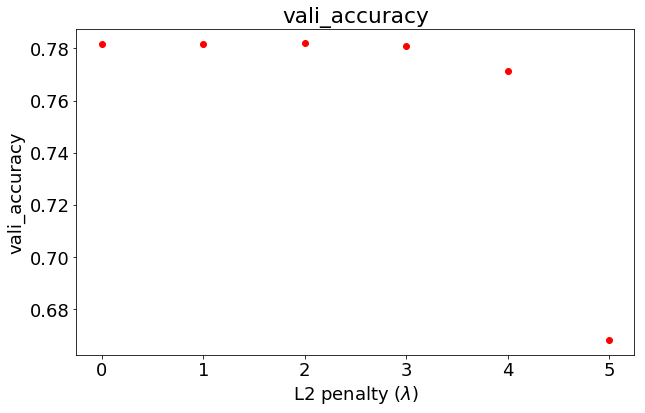

In [108]:
vali_accuracy = []
for coefficient in [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty]:
    predictions = predict_probability(feature_matrix_valid, coefficient)  
    correct_num = np.sum((np.transpose(predictions.flatten())> 0.5) == (np.array(sentiment_valid)>0))
    total_num = len(sentiment_valid)
    #print "correct_num: {}, total_num: {}".format(correct_num, total_num)
    vali_accuracy.append(correct_num * 1./ total_num)
    #print accuracy
l2_penalty_list=[x for x in range(6)]
plt.plot(l2_penalty_list, vali_accuracy,'ro')
plt.title('vali_accuracy')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('vali_accuracy')
plt.show()

In [109]:
print("model (L2 = {}) has the highest accuracy on the validation data with validation accuracy of {}".format([0, 4, 10, 1e2, 1e3, 1e5][vali_accuracy.index(max(vali_accuracy))] , vali_accuracy[vali_accuracy.index(max(vali_accuracy))]))

model (L2 = 10) has the highest accuracy on the validation data with validation accuracy of 0.7819064513117356


At the end highest accuracy on the training data does not imply that the model is the best one